In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit
import re as re
import matplotlib as matplotlib
import random
%matplotlib inline

# Useful Functions


The functions below load the dilatometer data from the deformation file - which records data during deformation at the highest acquisition frequency, but excludes the heating and cooling stages. 

Deformation data can also be analysed from the basic file (recorded at a lower acquisition frequency), by extracting only the data relevant to the deformation test, stripping away the heating and cooling data after unload - see commented lines.

In [2]:
def get_stress_strain(data,interval=50, offset=200):
    points=data[:,0]
    force=data[:,4]
    strain=data[:,5]
    TrueStress=data[:,6]
    TrueStrain=data[:,7]
    deltaL=data[:,3]

#     grad_force=(np.gradient(force[::interval]))
#     test_start=np.where(grad_force==np.max(grad_force))
#     test_end=np.where(grad_force==np.min(grad_force))
#     point_start=int(points[::interval][test_start])-offset
#     point_end=int(points[::interval][test_end])
#     stress= TrueStress[point_start:point_end]
#     strain= TrueStrain[point_start:point_end]

    stress=TrueStress
    strain=TrueStrain
    load=force
    displacement=deltaL
    
    return stress,strain,load,displacement

The function below takes a file list and loads the clean data into a dictionary, indexed by filename:

In [3]:
def clean_data(file_list):
    tests={}
    for filename in file_list:
        f=open(filename,'r',encoding='latin-1')
        data=np.loadtxt(f, skiprows=3)   
        s,e,l,d=get_stress_strain(data)
        tests[str(filename)]=(s,e,l,d)
    return tests

Change of directory to access the data:

In [4]:
cd compression_dilatometer_data_ZrNb/deformation_files

/Users/mbcx9cd4/Dropbox (Research Group)/LightForm Postdoc/Masters Projects/compression_dilatometer_ZrNb/compression_dilatometer_data_ZrNb/deformation_files


In [5]:
filenames = sorted(glob('*.asc'))
filenames = filenames[:]
tests=clean_data(filenames)

In [6]:
def plot_stress_strain(data):
    stress=data[0]
    strain=data[1]
    plt.plot(strain, stress,color='C2',marker='o')

In [7]:
def get_test_params(filename):
#     matches=re.search('(\d+)_+(\d+)_([-\d\.]+)_(\d\d)\.asc',filename)
    matches=re.search('(\d+)_+(\d+)_([-\d\.]+)_(\d\d)\_1.asc',filename)
    test=matches[1]
    temp=matches[2]
    strain_rate=str(float(matches[3]))
    attempt=matches[4]
    return test,temp,strain_rate,attempt

General plotting parameters;

In [8]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('axes',linewidth=1)
plt.rc('xtick.major',width=1,size=10)
plt.rc('xtick.minor', width=1, size=5)
plt.rc('ytick.major',width=1,size=10)
plt.rc('ytick.minor',width=1,size=5)

Plotting a dataset to find the elastic region:

In [9]:
# data=tests['172_650_1.0_01_1.asc']
# data=tests['184_775_1.0_01_1.asc']
data=tests['044_700_-1.5_02_1.asc']
s=data[0]
e=data[1]
l=data[2]
d=data[3]

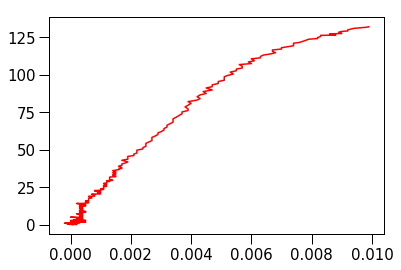

In [10]:
plt.figure()
# plt.plot(e,s,'o-')
e_strain=e[np.where(e <0.01)]
e_stress=s[np.where(e <0.01)]
e_strain=e_strain[np.where(e_stress>0.0)]
e_stress=e_stress[np.where(e_stress>0.0)]
plt.plot(e_strain,e_stress,'r')

In [11]:
def elastic(strain,E,c):
    return strain*E+c

def proof_stress(strain,stress,elasticStrain,stressElastic, plotting = False):
    proof_vals=dict()
    fit,var=curve_fit(elastic,elasticStrain,stressElastic) 
    strain_fit=np.linspace(0,0.1,np.max(np.where(strain<0.006)))
    stress_fit=elastic(strain_fit,fit[0],fit[1])
    for proof in [0.002,0.005,0.5]:
        proof_strain=strain_fit+proof
        stress_range = stress[np.where(strain<proof_strain[-1])]
        strain_range = strain[np.where(strain<proof_strain[-1])]
        strain_diff_list=[]
        for (stress_val,strain_val) in zip(stress_range,strain_range):
            strain_guess=np.interp(stress_val,stress_fit,proof_strain)
            strain_diff=strain_guess-strain_val
            strain_diff_list.append(np.abs(strain_diff))
        stress_intercept=stress_range[np.where(strain_diff_list==np.min(strain_diff_list))]
        strain_intercept=strain_range[np.where(strain_diff_list==np.min(strain_diff_list))]
#         proof_vals[str(proof)]=[strain_intercept,stress_intercept]
        proof_vals[str(proof)]=[strain_intercept[0],stress_intercept[0]]
    if plotting == True:
        plt.figure()
        plt.plot(strain,stress,'o',alpha=0.5)
        plt.plot(strain_fit,stress_fit,'r')
        plt.plot(strain_fit+0.002,stress_fit,'g') #add 0.2% or 0.002 for 0.2% proof stress
        plt.plot(strain_fit+0.005,stress_fit,'y') #add 0.5% or 0.005 for 0.5% proof stress
        plt.legend(('Stress-Strain','Elastic','0.2% proof','0.5% proof'),loc=0)
        plt.xlabel('Strain',fontsize=15)
        plt.ylabel('Stress (MPa)',fontsize=15)
        plt.xlim([0,0.6])  
        plt.ylim(ymin=0,ymax=300)
    return proof_vals

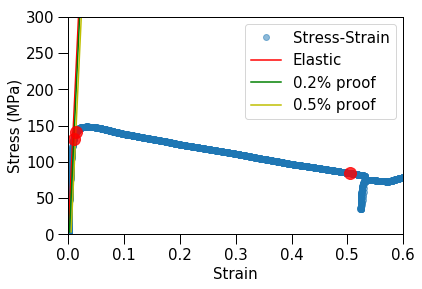

In [12]:
proof_vals=proof_stress(e,s,e_strain,e_stress,plotting=True)
for proof,values in proof_vals.items():
    plt.plot(values[0],values[1],'ro',ms=12.0,alpha=0.8)

In [13]:
def fit_test(filename,plotting=False):
    data=tests[filename]
    s=data[0]
    e=data[1]
    e_strain=e[np.where(e <0.01)]
    e_stress=s[np.where(e <0.01)]
    e_strain=e_strain[np.where(e_stress>0.0)]
    e_stress=e_stress[np.where(e_stress>0.0)]
    proof_vals=proof_stress(e,s,e_strain,e_stress,plotting)
    if plotting == True:
        for proof,values in proof_vals.items():
            plt.plot(values[0],values[1],'ro',ms=12.0,alpha=0.8)
    return proof_vals

{'0.002': [0.0098, 141.6304],
 '0.005': [0.0131, 147.6464],
 '0.5': [0.5056, 100.74]}

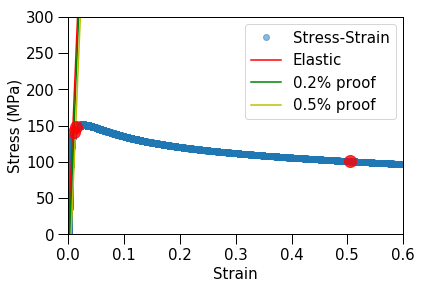

In [14]:
vals=fit_test('001_650_-2.5_01_1.asc',plotting=True)
# vals=fit_test('184_775_1.0_01_1.asc',plotting=True)
vals

We can load all files and use an exceptions list to ignore any problematic files (if there were any):

In [15]:
exceptions=['none.asc']
# exceptions=['044_700_-1.5_02_1.asc']
filenames = sorted(glob('*.asc'))
tests=clean_data(filenames)
proof_vals={}
for file in filenames:
    if file not in exceptions:
        vals=fit_test(file)
        proof_vals[file]=vals

## Plotting Stress Strain Data

In [16]:
def plot_all(tests):
    
    # create lists of unique temperatures and strain rates
    temp_list=[]
    strain_rate_list=[]
    for key in tests.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temp_list.append(temp)
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    temps= list(np.unique(temp_list))
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))

    # create dictionaries for plot positions and plotting colours
    plt_temps={}
    plt_strain_rates={}
    plt_pos=[(0,0),(0,1),(0,2),
             (1,0),(1,1),(1,2),
             (2,0),(2,1),(2,2)]
    for temp, pos in zip(temps, plt_pos):
        plt_temps[temp]=pos
#     plt_colors = ['C0','C1','C2','C3','C4','C5', 'C6', 'C7']
#     plt_colors = ['darkgray','darkviolet','blue','deepskyblue','lawngreen','orange','red','firebrick']
#     plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44', 'black']
    plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44']
    for strain_rate,color in zip(strain_rates,plt_colors):
        plt_strain_rates[str(strain_rate)]=color

    # set up subplots and plot data 
    f,ax=plt.subplots(3,3,sharex='all',sharey='all',figsize=(15,15))
    for filename,data in tests.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        pos=plt_temps[temp]
        col=plt_strain_rates[str(float(strain_rate))]
        ax[pos].plot(data[1],data[0],color=col,linewidth=1)

    # add legend with matching colours    
    ax[1,2].legend(strain_rates, title= 'log(Strain Rate)',loc='center left',fontsize=20, bbox_to_anchor=(1, 0.5), frameon=False)
    leg = ax[1,2].get_legend()
    plt.setp(leg.get_title(),fontsize=20)
    for l,color in zip(leg.legendHandles,plt_colors):
        l.set_color(color)
        
    # add title and axis labels
    plt.xlim(-0.025,0.6825)
    plt.tight_layout
    ax[1,0].set_ylabel('True Stress (MPa)',fontsize=25)
    ax[2,1].set_xlabel('True Strain, ${\epsilon}$',fontsize=25)
    for temp,pos in plt_temps.items():
        ax[pos].set_title('$'+str(temp)+'^\circ\mathrm{C}$', fontsize=15)
        
    plt.savefig('all.png', bbox_inches='tight')

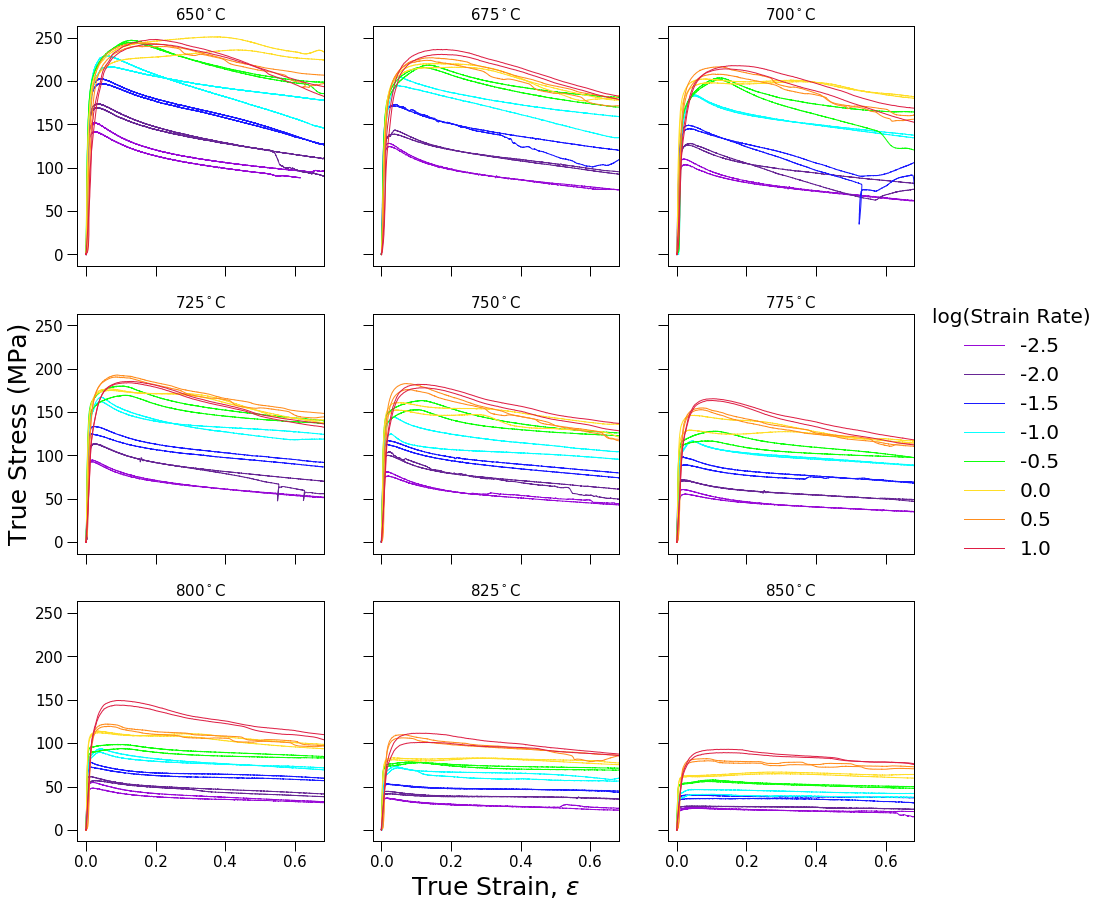

In [17]:
plot_all(tests)

We can also include the proof stress at 0.5 strain on this plot:

In [18]:
def plot_all_proof(tests,proof_vals):
    
    # create lists of unique temperatures and strain rates
    temp_list=[]
    strain_rate_list=[]
    for key in tests.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temp_list.append(temp)
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    temps= list(np.unique(temp_list))
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))

    # create dictionaries for plot positions and plotting colours
    plt_temps={}
    plt_strain_rates={}
    plt_pos=[(0,0),(0,1),(0,2),
             (1,0),(1,1),(1,2),
             (2,0),(2,1),(2,2)]
    for temp, pos in zip(temps, plt_pos):
        plt_temps[temp]=pos     
#     plt_colors = ['C0','C1','C2','C3','C4','C5', 'C6', 'C7']
#     plt_colors = ['darkgray','darkviolet','blue','deepskyblue','lawngreen','orange','red','firebrick']
#     plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44', 'black']
    plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44']               
    for strain_rate,color in zip(strain_rates,plt_colors):
        plt_strain_rates[str(strain_rate)]=color

    # set up subplots and plot data 
    f,ax=plt.subplots(3,3,sharex='all',sharey='all',figsize=(15,15))
    for filename,data in tests.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        pos=plt_temps[temp]
        col=plt_strain_rates[str(float(strain_rate))]
        ax[pos].plot(data[1],data[0],color=col)        
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        pos=plt_temps[temp]
        col=plt_strain_rates[str(float(strain_rate))]       
        proof_stress=proof_stresses['0.5'][0]
        proof_strain=proof_stresses['0.5'][1]
        ax[pos].plot(proof_stress,proof_strain,'ro',ms=10.0,alpha=0.5)      
        
    # add legend with matching colours    
    ax[1,2].legend(strain_rates, title= 'log(Strain Rate)',loc='center left', fontsize=20, bbox_to_anchor=(1, 0.5),frameon=False)
    leg = ax[1,2].get_legend()
    plt.setp(leg.get_title(),fontsize=20)
    for l,color in zip(leg.legendHandles,plt_colors):
        l.set_color(color)
        
    #add title and axis labels
    plt.xlim(-0.025,0.6825)
    ax[1,0].set_ylabel('True Stress (MPa)',fontsize=25)
    ax[2,1].set_xlabel('True Strain, ${\epsilon}$',fontsize=25)
    for temp,pos in plt_temps.items():
        ax[pos].set_title('$'+str(temp)+'^\circ\mathrm{C}$',fontsize=15)
        
    plt.savefig('all_proof.png', bbox_inches='tight')

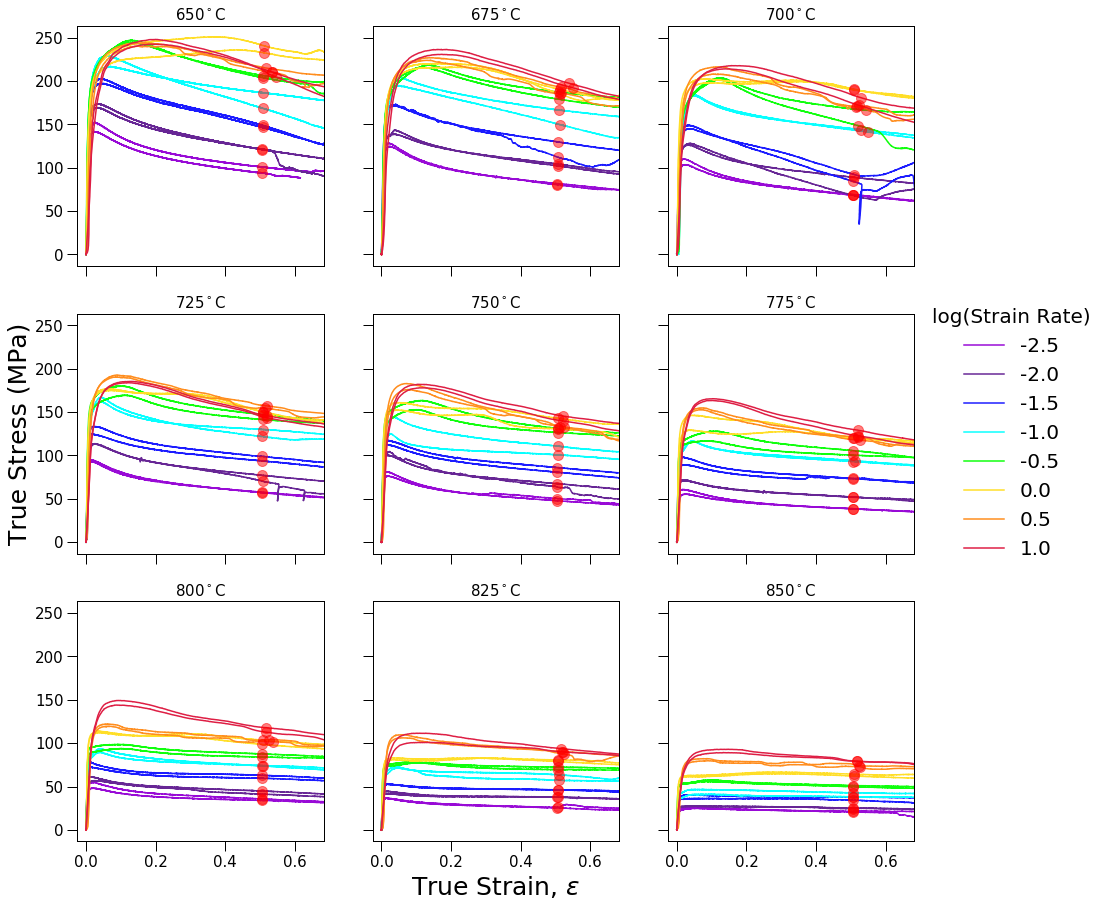

In [19]:
plot_all_proof(tests,proof_vals)

A summary of the true stress-strain behaviour, plotting all temperatures at a single strain rate and all strain rates at a single temperature:

In [20]:
def plot_summary(tests):
    
    # create lists of unique temperatures and strain rates
    temp_list=[]
    strain_rate_list=[]
    for key in tests.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temp_list.append(temp)
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    temps= list(np.unique(temp_list))
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))

    # create dictionaries for plot positions and plotting colours
    plt_temps={}
    plt_strain_rates={}
    plt_pos=[(0,0),(0,1)]        
    plt_colors_T = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44', 'black']
    plt_colors_SR = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44'] 
    for strain_rate,color in zip(strain_rates,plt_colors_SR):
        plt_strain_rates[str(strain_rate)]=color      
    for temp, color in zip(temps,plt_colors_T):
        plt_temps[str(temp)]=color

    # set up subplots and plot data 
    f,ax=plt.subplots(1,2,sharex='all',figsize=(15,5))
    for filename,data in tests.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        if strain_rate=='-2.5':
            col=plt_temps[str(temp)]
            ax[0].plot(data[1],data[0],color=col,linewidth=1.5)
            ax[0].set_ylim([-10,160])
        if temp=='800':
            col=plt_strain_rates[str(float(strain_rate))]
            ax[1].plot(data[1],data[0],color=col,linewidth=1.5)
            ax[1].set_ylim([-10,160])
            
    # add legend with matching colours    
    ax[0].legend(temps, title= 'Temperature ($^\circ\mathrm{C}$)',loc='upper center',fontsize=20, bbox_to_anchor=(0.5, 1.50), ncol=3,frameon=False)
    leg1 = ax[0].get_legend()
    ax[1].legend(strain_rates, title= 'log(Strain Rate)',loc='upper center',fontsize=20, bbox_to_anchor=(0.5, 1.50),ncol=3,frameon=False)
    leg2 = ax[1].get_legend()
    for l,color in zip(leg1.legendHandles,plt_colors_T):
        l.set_color(color)
    for l,color in zip(leg2.legendHandles,plt_colors_SR):
        l.set_color(color)
    
    # add title and axis labels
    plt.xlim(-0.025,0.6825)
    f.tight_layout
    ax[0].set_ylabel('True Stress (MPa)',fontsize=20)
    ax[1].set_ylabel('True Stress (MPa)',fontsize=20)
    ax[0].set_xlabel('True Strain, ${\epsilon}$',fontsize=20)
    ax[1].set_xlabel('True Strain, ${\epsilon}$',fontsize=20)
    plt.setp(leg1.get_title(),fontsize=20)
    plt.setp(leg2.get_title(),fontsize=20)
    
    plt.savefig('summary.png', bbox_inches='tight')

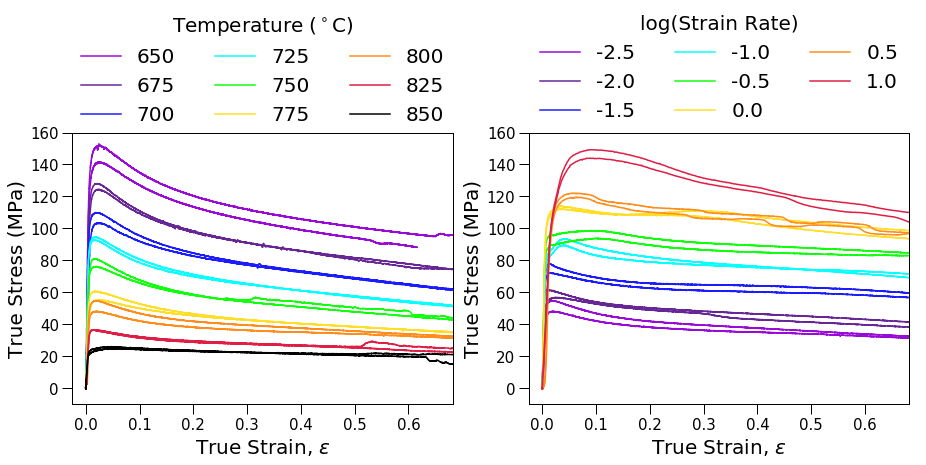

In [21]:
plot_summary(tests)

The difference between a force-displacement plot and the 'notional' true stress versus true strain:

In [22]:
def plot_comparison(tests):
    
    # create lists of unique temperatures and strain rates
    temp_list=[]
    strain_rate_list=[]
    for key in tests.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temp_list.append(temp)
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    temps= list(np.unique(temp_list))
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))

    # create dictionaries for plot positions and plotting colours
    plt_strain_rates={}
    plt_pos=[(0,0),(0,1)]        
    plt_colors_SR = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44']
    
    for strain_rate,color in zip(strain_rates,plt_colors_SR):
        plt_strain_rates[str(strain_rate)]=color      

    # set up subplots and plot data 
    f,ax=plt.subplots(1,2,figsize=(15,5))
    for filename,data in tests.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        if attempt=='01':
            if temp=='750':
                col=plt_strain_rates[str(float(strain_rate))]
                ax[0].plot((data[3]*-1)/1000,data[2]/1000,color=col,linewidth=1.5)
                ax[1].plot(data[1],data[0],color=col,linewidth=1.5)
                ax[0].set_xlim([-0.2,4.95])
            
    # add legend with matching colours    
    ax[1].legend(strain_rates, title= 'log(Strain Rate)',loc='upper center',fontsize=20, bbox_to_anchor=(1.25, 1.025), frameon=False)
    leg = ax[1].get_legend()
    for l,color in zip(leg.legendHandles,plt_colors_SR):
        l.set_color(color)
    
    # add title and axis labels
    plt.xlim(-0.025,0.6825)
    f.tight_layout
    ax[0].set_ylabel('Force (kN)',fontsize=20)
    ax[1].set_ylabel('Notional True Stress (MPa)',fontsize=20)
    ax[0].set_xlabel('Displacement (mm)',fontsize=20)
    ax[1].set_xlabel('Notional True Strain, ${\epsilon}$',fontsize=20)
    plt.setp(leg.get_title(),fontsize=20)
    
    plt.savefig('comparison.png', bbox_inches='tight')

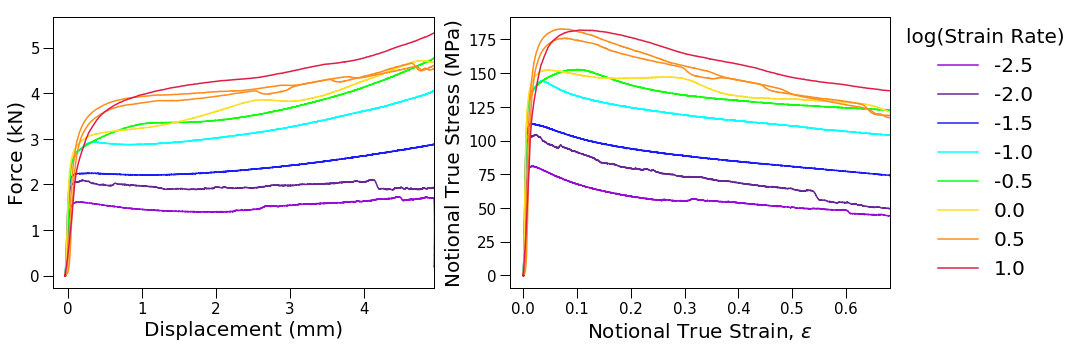

In [23]:
plot_comparison(tests)

## Getting and Plotting All Proof Stresses

In [24]:
def plot_proof_stress(proof_vals):

    strain_rate_list=[]
    for key in proof_vals.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))
    
    strain_rate_dict={}
    
    for strain_rate in strain_rates:
        strain_rate_dict[str(strain_rate)]=[[],[]]
    
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        strain_rate=str(float(strain_rate))
        proof_stress=proof_stresses['0.5'][1]
        temperature=float(temp)
        strain_rate_dict[strain_rate][0].append(temp)
        strain_rate_dict[strain_rate][1].append(proof_stress)
    return strain_rate_dict   

In [25]:
proof_vals.items()

dict_items([('001_650_-2.5_01_1.asc', {'0.002': [0.0098, 141.6304], '0.005': [0.0131, 147.6464], '0.5': [0.5056, 100.74]}), ('002_650_-2.5_02_1.asc', {'0.002': [0.0094, 131.6457], '0.005': [0.0127, 136.6966], '0.5': [0.5053, 93.9716]}), ('003_650_-2_01_1.asc', {'0.002': [0.0105, 153.6409], '0.005': [0.0139, 160.7096], '0.5': [0.5067, 121.2269]}), ('004_650_-2_02_1.asc', {'0.002': [0.0104, 154.7357], '0.005': [0.0139, 163.6207], '0.5': [0.5066, 120.8656]}), ('005_650_-1.5_01_1.asc', {'0.002': [0.0107, 172.6995], '0.005': [0.0144, 185.3228], '0.5': [0.5075, 148.6954]}), ('007_650_-1.5_02_1.asc', {'0.002': [0.011, 167.2866], '0.005': [0.0147, 180.2984], '0.5': [0.5079, 146.2569]}), ('008_650_-1_01_1.asc', {'0.002': [0.0105, 166.2506], '0.005': [0.0142, 179.8072], '0.5': [0.5095, 186.2826]}), ('009_650_-1_02_1.asc', {'0.002': [0.01, 179.7435], '0.005': [0.0136, 193.4772], '0.5': [0.5075, 168.474]}), ('017_650_-0.5_01_1.asc', {'0.002': [0.0098, 179.5953], '0.005': [0.0134, 192.941], '0.5': 

In [26]:
a=plot_proof_stress(proof_vals)

Text(0,0.5,'Stress (MPa)')

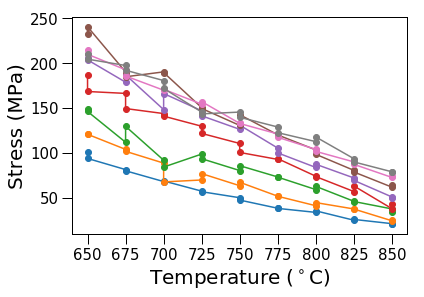

In [27]:
for strain_rate, data in a.items():

    log_stress=np.log10(np.array(data[1]))
    plt.plot(data[0],data[1],'o-')
    
plt.xlabel ('Temperature ($^\circ\mathrm{C}$)',fontsize='20')
plt.ylabel('Stress (MPa)',fontsize='20')

Then, a function to get the data ready for the strain rate sensitivity plot:

In [28]:
def plot_proof_stress_temp(proof_vals,n=3):

    temperature_list=[]
    for key in proof_vals.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temperature_list.append(temp)
    
    temperature_dict={}
    
    for temp in temperature_list:
        temperature_dict[temp]=[[],[]]
    
    plt.figure(figsize=(12,8))
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.rc('legend',fontsize=20)
    plt.rc('axes',linewidth=2)
    plt.rc('xtick.major',width=2,size=10)
    plt.rc('xtick.minor', width=2, size=5)
    plt.rc('ytick.major',width=2,size=10)
    plt.rc('ytick.minor',width=2,size=5)
    
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        strain_rate=float(strain_rate)
        proof_stress=proof_stresses['0.5'][1]
        temperature=str(temp)
        temperature_dict[temp][0].append(strain_rate)
        temperature_dict[temp][1].append(proof_stress)
        
        fit_pars={}
        temp_colors={}
        temp_markers={}
        temps=[]
        #plt_colors = ['C0','C1','C2','C3','C4','C5', 'C6', 'C7','C8']
        #plt_colors = ['black','#DE1E44','#FF8D1D','#FFDE27','#0FFF0D','#08FFFF','#1B1BFF','#672695','#980AD6']
        plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44','black']
        plt_markers = ['o','s','D','v','^','<','>','X','P',]
        for temp,color,marker in zip(temperature_dict.keys(),plt_colors,plt_markers):
            temp_colors[temp]=color
            temp_markers[temp]=marker
            temps.append(temp)

    for temp, data in temperature_dict.items():
        log_stress=np.log10(np.array(data[1]))
        log_strain_rate=np.array(data[0])
        plt.plot(log_strain_rate, log_stress,marker=temp_markers[temp],linestyle='none',markersize=10, color=temp_colors[temp])

    for temp, data in temperature_dict.items():
        log_stress=np.log10(np.array(data[1]))
        log_strain_rate=np.array(data[0])
        fit_stress=np.polyfit(log_strain_rate,log_stress,n)
        fit_pars[temp]=fit_stress
        strain_rate_fit=np.linspace(log_strain_rate.min(), log_strain_rate.max(),20)
        plt.plot(strain_rate_fit,np.polyval(fit_stress,strain_rate_fit),'--',linewidth=3, color=temp_colors[temp])
    
    plt.ylim(0.7125,2.475)
    plt.xlim(-3.175,1.175) 
    plt.xlabel('$\log (\dot{\epsilon})$',fontsize=25)
    plt.ylabel('$\log (\sigma)$',fontsize=25)
    legend=plt.legend(temps, title= 'Temperature \n      ($^\circ$C)', fontsize=25,loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
    plt.setp(legend.get_title(),fontsize=25)
    
    plt.savefig('proof.png', bbox_inches='tight')
    
    return fit_pars

## Processing Map with 3rd Order Polynomial (Cubic Fit)

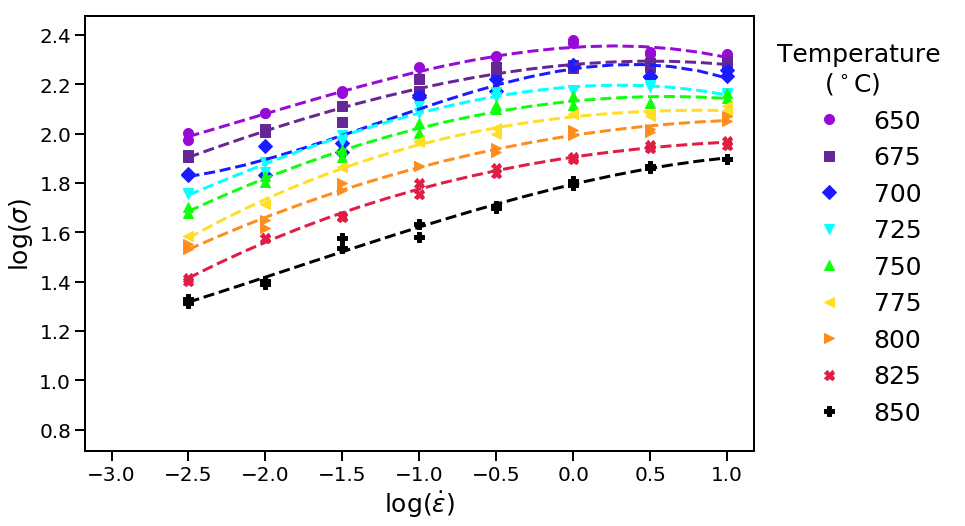

In [29]:
fit_pars3=plot_proof_stress_temp(proof_vals)

In [30]:
def plot_m_contour(fit_pars,strain_rate_levels=20):    
    log_strain_rate=np.linspace(-2.5,1.0,strain_rate_levels)
    m_list=[]
    temps=fit_pars.keys()
    for temp in sorted(temps):
        pars=fit_pars[str(temp)]
        if len(pars)==4:
            m=3*pars[0]*log_strain_rate**2+2*pars[1]*log_strain_rate+pars[2]
        elif len(pars)==3:
            m=2*pars[0]*log_strain_rate+pars[1]
        elif len(pars)==2:
            m=pars[0]*log_strain_rate/log_strain_rate
        else:
            m=0*log_strain_rate/log_strain_rate
        m_list.append(m)
    m_array=np.array(m_list)
    plt.figure(figsize=(12,8))
    plt.contourf(temps,log_strain_rate,m_array.T,20, cmap='viridis',vmin=0,vmax=0.3)
    plt.ylabel(r'$\log (\dot{\epsilon})$',fontsize=25)
    plt.xlabel(r'Temperature $(^\circ$C)',fontsize=25)
    plt.colorbar()
    
    plt.savefig('contour.png', bbox_inches='tight')

In [31]:
fit_pars3

{'650': array([-0.01100731, -0.06962078,  0.03953519,  2.35014287]),
 '675': array([-0.00377365, -0.04873858,  0.05225066,  2.28047038]),
 '700': array([-0.02627101, -0.10010827,  0.08870862,  2.26273823]),
 '725': array([-0.00697391, -0.0701143 ,  0.04380881,  2.19009412]),
 '750': array([-9.97503510e-04, -4.94543916e-02,  6.12609595e-02,  2.13181115e+00]),
 '775': array([ 0.00329417, -0.04401699,  0.06595432,  2.06852864]),
 '800': array([ 5.73891315e-04, -3.47289899e-02,  9.44712518e-02,  1.99317091e+00]),
 '825': array([ 0.00285438, -0.0344561 ,  0.0921424 ,  1.90512776]),
 '850': array([-0.00614889, -0.03326542,  0.14639876,  1.79506994])}

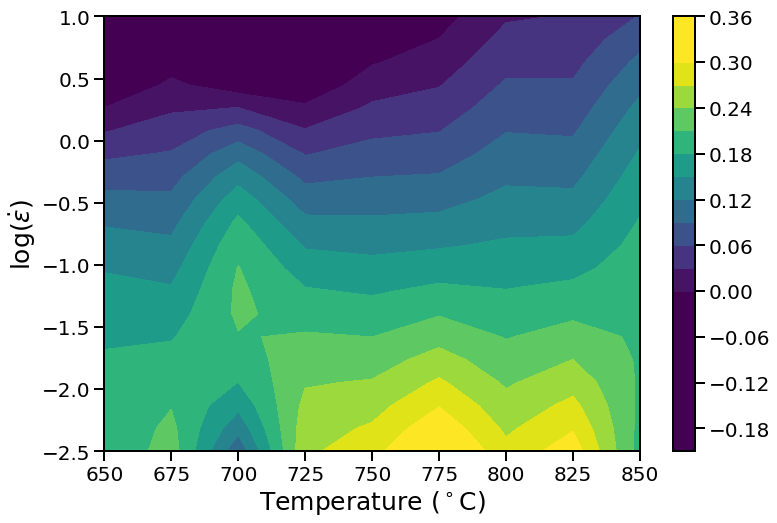

In [32]:
plot_m_contour(fit_pars3)

## Processing Map with 2nd Order Polynomial (Quadratic Fit)

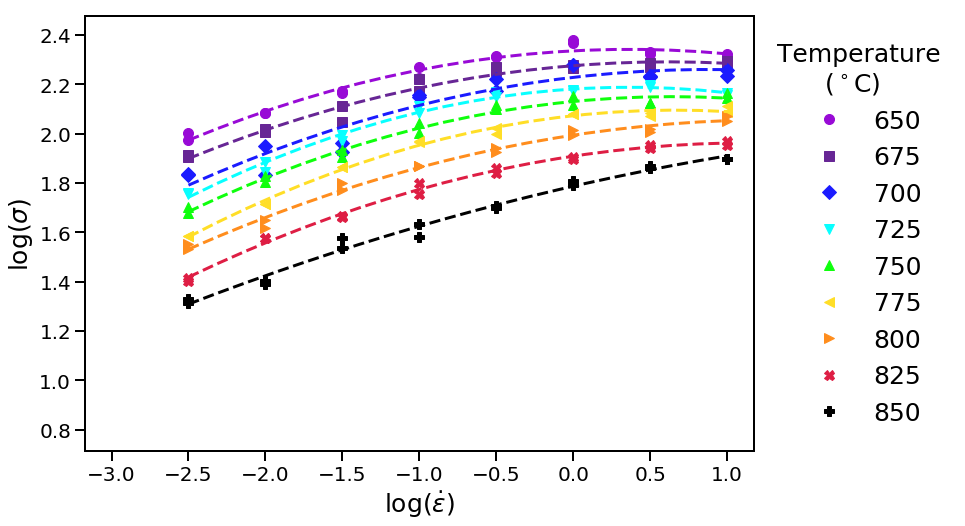

In [33]:
fit_pars2=plot_proof_stress_temp(proof_vals,n=2)

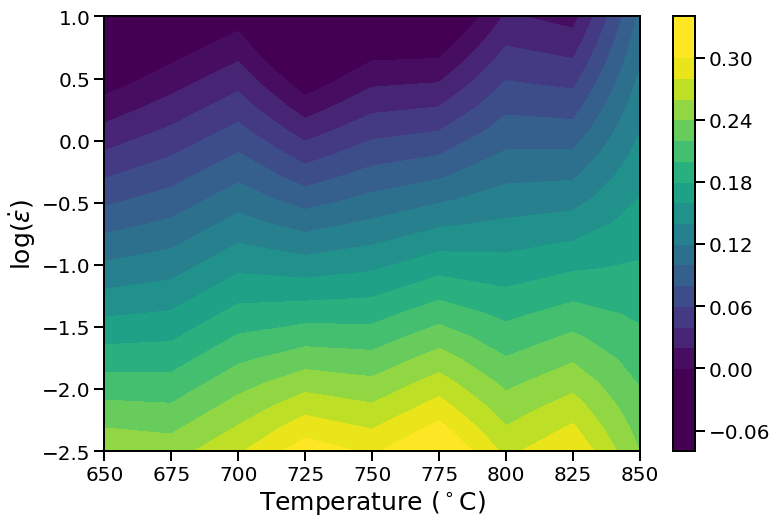

In [34]:
plot_m_contour(fit_pars2)

## Adding Random Noise to the Data ( +/- 5 MPa )

In [35]:
def plot_proof_stress_random(proof_vals,n=3,rand_val=0.05,plotting=True):

    temperature_list=[]
    for key in proof_vals.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temperature_list.append(temp)
    
    temperature_dict={}
    
    for temp in temperature_list:
        temperature_dict[temp]=[[],[]]
    
    plt.figure(figsize=(12,8))
    
    plt.figure(figsize=(12,8))
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.rc('legend',fontsize=20)
    plt.rc('axes',linewidth=2)
    plt.rc('xtick.major',width=2,size=10)
    plt.rc('xtick.minor', width=2, size=5)
    plt.rc('ytick.major',width=2,size=10)
    plt.rc('ytick.minor',width=2,size=5)
    
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        strain_rate=float(strain_rate)
        proof_stress=randomize(proof_stresses['0.5'][1],rand_val)
        temperature=str(temp)
        temperature_dict[temp][0].append(strain_rate)
        temperature_dict[temp][1].append(proof_stress)
        
        fit_pars={}
        temp_colors={}
        temp_markers={}
        temps=[]
        #plt_colors = ['C0','C1','C2','C3','C4','C5', 'C6', 'C7','C8']
        plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44','black']
        plt_markers = ['o','s','D','v','^','<','>','X','P',]
        for temp,color,marker in zip(temperature_dict.keys(),plt_colors,plt_markers):
            temp_colors[temp]=color
            temp_markers[temp]=marker
            temps.append(temp)

    for temp, data in temperature_dict.items():
        log_stress=np.log10(np.array(data[1]))
        log_strain_rate=np.array(data[0])
        if plotting==True:
            plt.plot(log_strain_rate, log_stress,marker=temp_markers[temp],linestyle='none', markersize=10, color=temp_colors[temp])

    for temp, data in temperature_dict.items():
        log_stress=np.log10(np.array(data[1]))
        log_strain_rate=np.array(data[0])
        fit_stress=np.polyfit(log_strain_rate,log_stress,n)
        fit_pars[temp]=fit_stress
        strain_rate_fit=np.linspace(log_strain_rate.min(), log_strain_rate.max(),20)
        if plotting==True:
            plt.plot(strain_rate_fit,np.polyval(fit_stress,strain_rate_fit),'--',linewidth=3, color=temp_colors[temp])
    if plotting==True:
        plt.ylim(1.125,2.475)
        plt.xlim(-2.675,1.175) 
        plt.xlabel('$\log (\dot{\epsilon})$',fontsize=25)
        plt.ylabel('$\log (\sigma)$',fontsize=25)
        legend=plt.legend(temps, title= 'Temperature \n      ($^\circ$C)', fontsize=25,loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
        plt.setp(legend.get_title(),fontsize=25)
    return fit_pars

def randomize(proof_stress,rand_val):
    #return proof_stress*(1 + rand_val*(random.random()-0.5))
    return proof_stress + rand_val*(random.random()-0.5)

<Figure size 864x576 with 0 Axes>

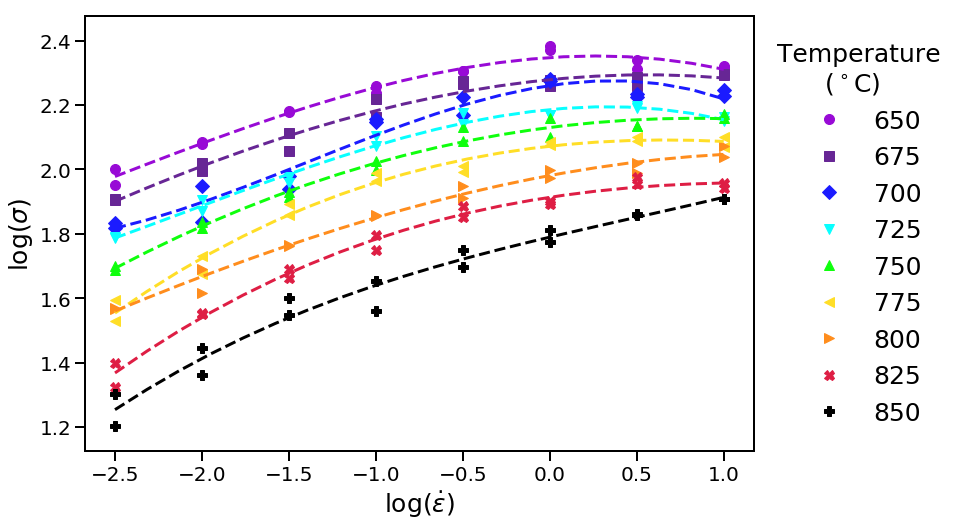

In [36]:
fit_pars_random=plot_proof_stress_random(proof_vals,n=3,rand_val=10)

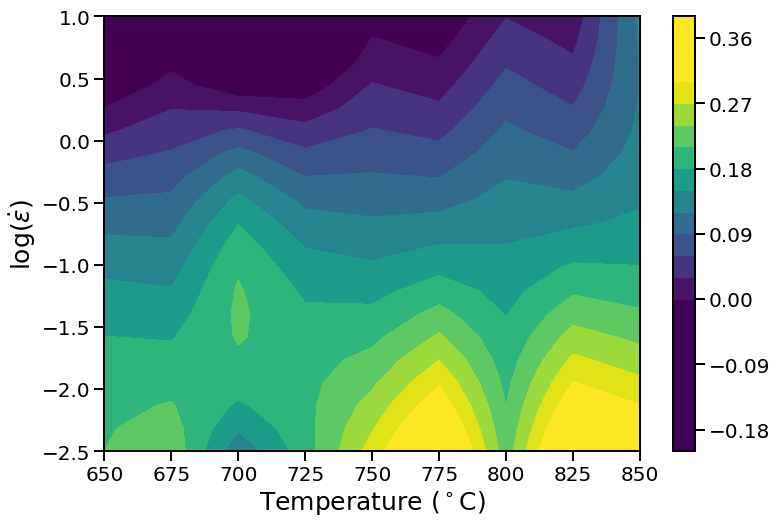

In [37]:
plot_m_contour(fit_pars_random)

In [38]:
def plot_m_contour_simple(fit_pars,ax,strain_rate_levels=20):    
    log_strain_rate=np.linspace(-2.5,1.0,strain_rate_levels)
    m_list=[]
    temps=fit_pars.keys()
    for temp in sorted(temps):
        pars=fit_pars[str(temp)]
        if len(pars)==4:
            m=3*pars[0]*log_strain_rate**2+2*pars[1]*log_strain_rate+pars[2]
        elif len(pars)==3:
            m=2*pars[0]*log_strain_rate+pars[1]
        elif len(pars)==2:
            m=pars[0]*log_strain_rate/log_strain_rate
        else:
            m=0*log_strain_rate/log_strain_rate
        m_list.append(m)
    m_array=np.array(m_list)
    ax.contourf(temps,log_strain_rate,m_array.T,20, cmap='viridis',vmin=-0.175,vmax=0.325);

An example of how 9 different plots with different random errors of +/- 5 MPa can look quite different:

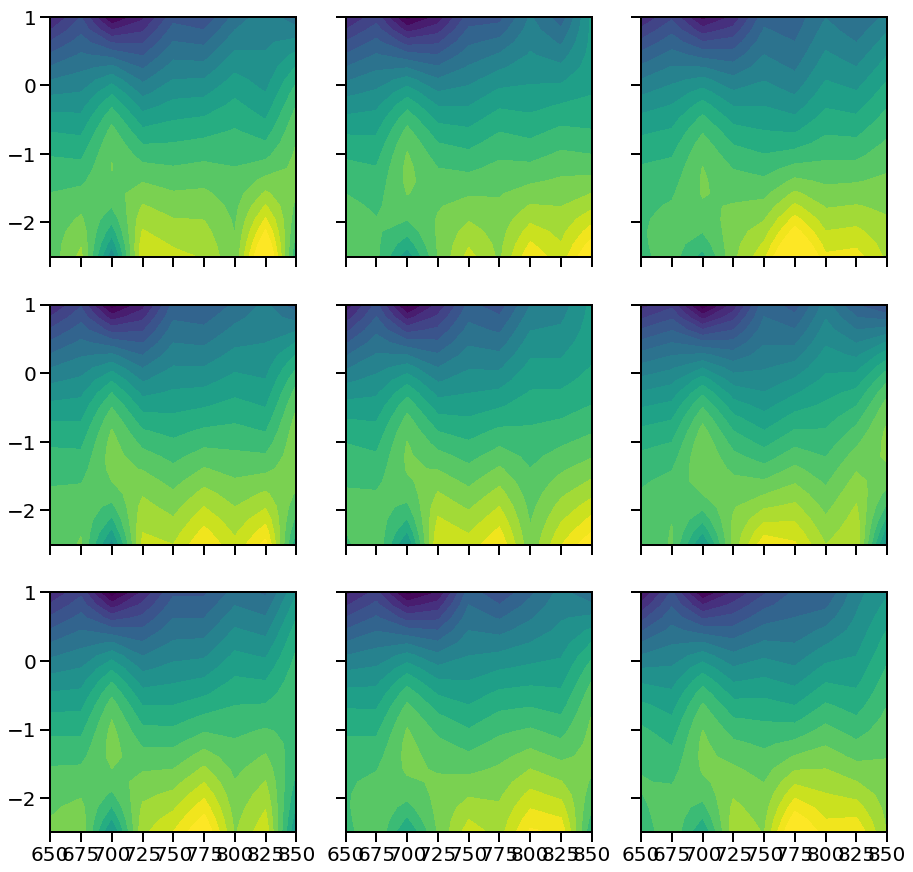

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [39]:
f,ax=plt.subplots(3,3,sharex='all',sharey='all',figsize=(15,15));
plt_pos=[(0,0),(0,1),(0,2),
             (1,0),(1,1),(1,2),
             (2,0),(2,1),(2,2)]

for pos in plt_pos:
    fit_pars_random=plot_proof_stress_random(proof_vals,n=3,rand_val=10,plotting=False)
    plot_m_contour_simple(fit_pars_random,ax[pos]);

# Using Fewer Points

Taking fewer points in temperature and strain rate from our large data set changes the contours of the processing map:

In [40]:
def plot_proof_stress_temp_select(proof_vals,n=3,strain_step=4):

    temperature_list=[]
    for key in proof_vals.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temperature_list.append(temp)
    
    temperature_dict={}
    
    for temp in temperature_list:
        temperature_dict[temp]=[[],[]]
    
    plt.figure(figsize=(12,8))
    
    plt.figure(figsize=(12,8))
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.rc('legend',fontsize=20)
    plt.rc('axes',linewidth=2)
    plt.rc('xtick.major',width=2,size=10)
    plt.rc('xtick.minor', width=2, size=5)
    plt.rc('ytick.major',width=2,size=10)
    plt.rc('ytick.minor',width=2,size=5)
    
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        strain_rate=float(strain_rate)
        proof_stress=proof_stresses['0.5'][1]
        temperature=str(temp)
        temperature_dict[temp][0].append(strain_rate)
        temperature_dict[temp][1].append(proof_stress)
        
        fit_pars={}
        temp_colors={}
        temp_markers={}
        temps=[]
        plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44','black']
        plt_markers = ['o','s','D','v','^','<','>','X','P',]
        for temp,color,marker in zip(temperature_dict.keys(),plt_colors,plt_markers):
            temp_colors[temp]=color
            temp_markers[temp]=marker
            temps.append(temp)

    for temp, data in temperature_dict.items():
#         for plotting every other point starting at 10-2.5s-1
#         if strain_step==1:
#             log_stress=np.log10(np.array(data[1]))[::4]
#             log_strain_rate=np.array(data[0])[::4]

#         for plotting every other point starting at 10-2s-1
#         if strain_step==2:
#             log_stress=np.log10(np.array(data[1]))[2:15:4]
#             log_strain_rate=np.array(data[0])[2:15:4]

#         for plotting every other point from 10-2s-1 and a point at 10-2.5s-1
#         if strain_step==3:
#             log_stress=np.log10(np.array(data[1]))[np.array((0,2,6,10,14))]
#             log_strain_rate=np.array(data[0])[np.array((0,2,6,10,14))]

#         for plotting every other point from 10-2s-1 and a point at 10-2.5s-1 (with repeats)
#         if strain_step==4:
#             log_stress=np.log10(np.array(data[1]))[np.array((0,1,2,3,6,7,10,11,14,15))]
#             log_strain_rate=np.array(data[0])[np.array((0,1,2,3,6,7,10,11,14,15))]
               
#         for plotting every other point starting at 10-2.5s-1 and a point at 1s-1 (with repeats)
#         if strain_step==5:
#             log_stress=np.log10(np.array(data[1]))[np.array((0,1,4,5,8,9,12,13,14,15))]
#             log_strain_rate=np.array(data[0])[np.array((0,1,4,5,8,9,12,13,14,15))]

        if temp == '700' or temp=='750' or temp=='800' or temp=='850':              
#             for plotting every other point starting at 10-2.5s-1
            if strain_step==1:
                log_stress=np.log10(np.array(data[1]))[::4]
                log_strain_rate=np.array(data[0])[::4]

#             for plotting every other point starting at 10-2s-1
            if strain_step==2:
                log_stress=np.log10(np.array(data[1]))[2:15:4]
                log_strain_rate=np.array(data[0])[2:15:4]

#             for plotting every other point from 10-2s-1 and a point at 10-2.5s-1
            if strain_step==3:
                log_stress=np.log10(np.array(data[1]))[np.array((0,2,6,10,14))]
                log_strain_rate=np.array(data[0])[np.array((0,2,6,10,14))]

#             for plotting every other point from 10-2s-1 and a point at 10-2.5s-1 (with repeats)
            if strain_step==4:
                log_stress=np.log10(np.array(data[1]))[np.array((0,1,2,3,6,7,10,11,14,15))]
                log_strain_rate=np.array(data[0])[np.array((0,1,2,3,6,7,10,11,14,15))]
               
#             for plotting every other point starting at 10-2.5s-1 and a point at 1s-1 (with repeats)
            if strain_step==5:
                log_stress=np.log10(np.array(data[1]))[np.array((0,1,4,5,8,9,12,13,14,15))]
                log_strain_rate=np.array(data[0])[np.array((0,1,4,5,8,9,12,13,14,15))]

            plt.plot(log_strain_rate, log_stress,marker=temp_markers[temp],linestyle='none',markersize=10, color=temp_colors[temp])
            
            fit_stress=np.polyfit(log_strain_rate,log_stress,n)
            fit_pars[temp]=fit_stress
#             strain_rate_fit=np.linspace(log_strain_rate.min(), log_strain_rate.max(),20)
            strain_rate_fit=np.linspace(-2.5, 1,20)
            plt.plot(strain_rate_fit,np.polyval(fit_stress,strain_rate_fit),'--',linewidth=3, color=temp_colors[temp])
        
    plt.ylim(0.7125,2.475)
    plt.xlim(-3.175,1.175)    
    plt.xlabel('$\log (\dot{\epsilon})$',fontsize=25)
    plt.ylabel('$\log (\sigma)$',fontsize=25)
    temp_list='700','700','750','750','800','800','850','850'
    legend=plt.legend(temp_list, title= 'Temperature \n      ($^\circ$C)', fontsize=25,loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
    plt.setp(legend.get_title(),fontsize=25)
    
    plt.savefig('reduced.png', bbox_inches='tight')
    
    return fit_pars

In [41]:
test=np.arange(15)
print(test)
test[np.array((0,5,12))]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


array([ 0,  5, 12])

<Figure size 864x576 with 0 Axes>

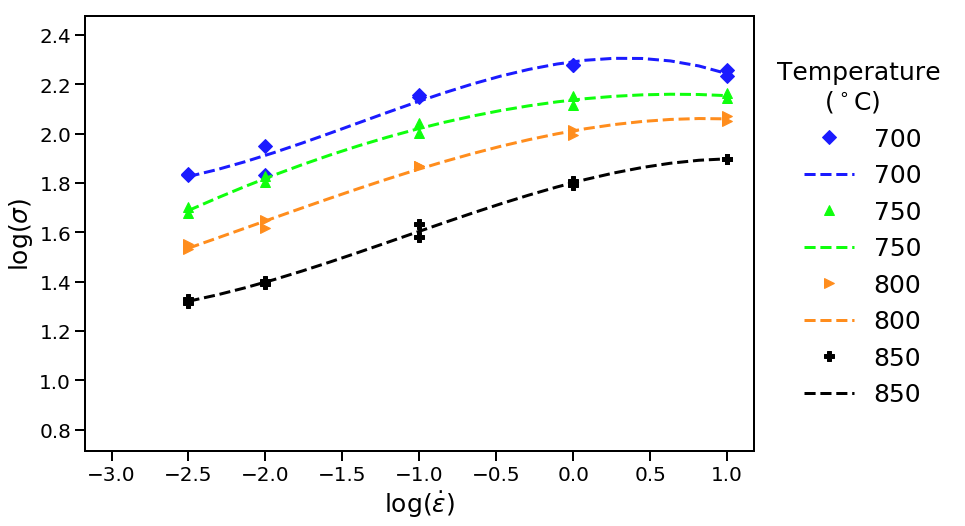

In [42]:
# stain_step=1 for plotting every other point starting at 10-2.5s-1
# stain_step=2 for plotting every other point starting at 10-2s-1
# stain_step=3 for plotting every other point from 10-2s-1 and a point at 10-2.5s-1
# stain_step=4 for plotting every other point from 10-2s-1 and a point at 10-2.5s-1 (with repeats)
# stain_step=5 for plotting every other point starting at 10-2.5s-1 and a point at 1s-1 (with repeats)

fit_pars_select=plot_proof_stress_temp_select(proof_vals,n=3,strain_step=4)

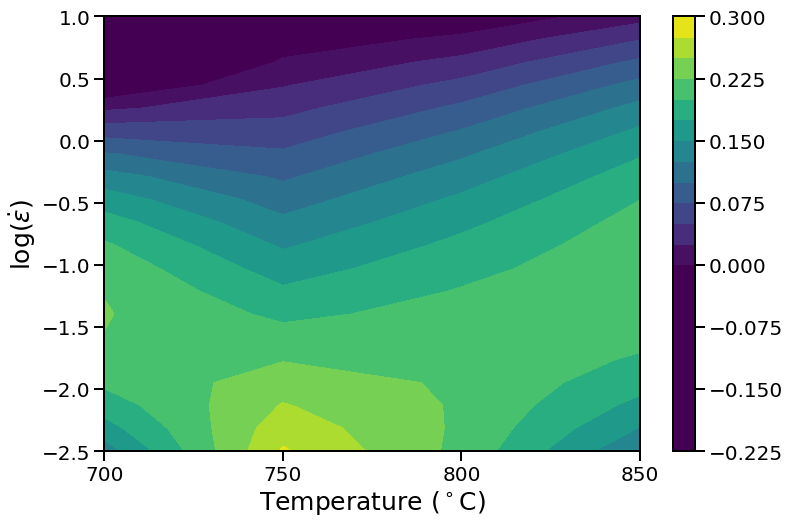

In [43]:
plot_m_contour(fit_pars_select)

Using fewer points, with a 2nd order polynomial (quadratic fit):

<Figure size 864x576 with 0 Axes>

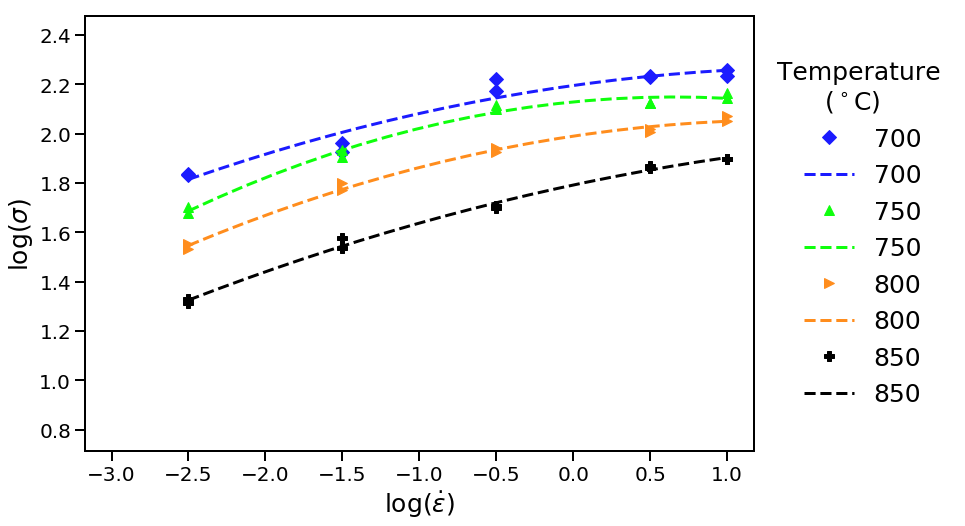

In [44]:
fit_pars_select=plot_proof_stress_temp_select(proof_vals,n=2,strain_step=5)

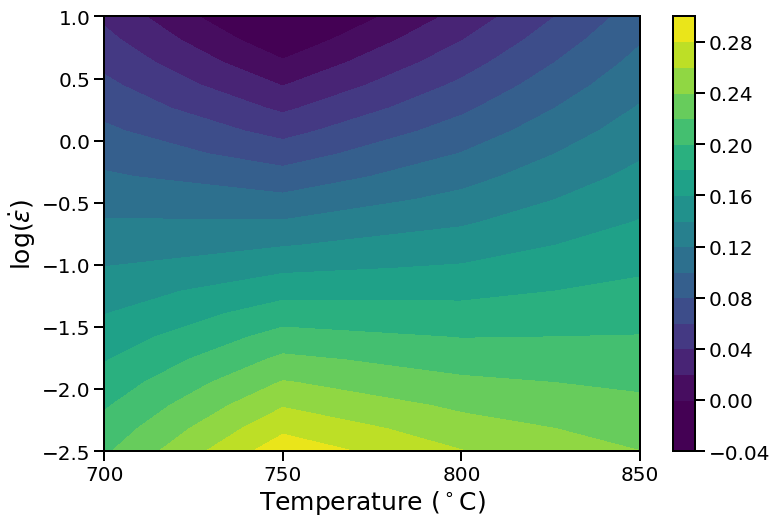

In [45]:
plot_m_contour(fit_pars_select)

# Trying Noise with Less Points

Having fewer points means random noise (or experimental uncertainty) will have a more significant effect on the contours of the processing map: 

In [46]:
def plot_proof_stress_random_select(proof_vals,n=3,rand_val=0.05,plotting=True,strain_step=4):

    temperature_list=[]
    for key in proof_vals.keys():
        test,temp,strain_rate,attempt=get_test_params(str(key))
        temperature_list.append(temp)
    
    temperature_dict={}
    
    for temp in temperature_list:
        temperature_dict[temp]=[[],[]]
    
    plt.figure(figsize=(12,8))
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.rc('legend',fontsize=20)
    plt.rc('axes',linewidth=2)
    plt.rc('xtick.major',width=2,size=10)
    plt.rc('xtick.minor', width=2, size=5)
    plt.rc('ytick.major',width=2,size=10)
    plt.rc('ytick.minor',width=2,size=5)
    
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params(filename)
        strain_rate=float(strain_rate)
        proof_stress=randomize(proof_stresses['0.5'][1],rand_val)
        temperature=str(temp)
        temperature_dict[temp][0].append(strain_rate)
        temperature_dict[temp][1].append(proof_stress)
        
        fit_pars={}
        temp_colors={}
        temp_markers={}
        temps=[]
#         plt_colors = ['C0','C1','C2','C3','C4','C5', 'C6', 'C7','C8']
        plt_colors = ['#980AD6','#672695','#1B1BFF','#08FFFF','#0FFF0D','#FFDE27','#FF8D1D','#DE1E44','black']
        plt_markers = ['o','s','D','v','^','<','>','X','P',]
        for temp,color,marker in zip(temperature_dict.keys(),plt_colors,plt_markers):
            temp_colors[temp]=color
            temp_markers[temp]=marker
            temps.append(temp)

    for temp, data in temperature_dict.items():
#       for plotting every other point starting at 10-2.5s-1
        if strain_step==1:
            log_stress=np.log10(np.array(data[1]))[::4]
            log_strain_rate=np.array(data[0])[::4]

#       for plotting every other point starting at 10-2s-1
        if strain_step==2:
            log_stress=np.log10(np.array(data[1]))[2:15:4]
            log_strain_rate=np.array(data[0])[2:15:4]

#       for plotting every other point from 10-2s-1 and a point at 10-2.5s-1
        if strain_step==3:
            log_stress=np.log10(np.array(data[1]))[np.array((0,2,6,10,14))]
            log_strain_rate=np.array(data[0])[np.array((0,2,6,10,14))]

#       for plotting every other point from 10-2s-1 and a point at 10-2.5s-1 (with repeats)
        if strain_step==4:
            log_stress=np.log10(np.array(data[1]))[np.array((0,1,2,3,6,7,10,11,14,15))]
            log_strain_rate=np.array(data[0])[np.array((0,1,2,3,6,7,10,11,14,15))]

#       for plotting every other point starting at 10-2.5s-1 and a point at 1s-1 (with repeats)
        if strain_step==5:
            log_stress=np.log10(np.array(data[1]))[np.array((0,1,4,5,8,9,12,13,14,15))]
            log_strain_rate=np.array(data[0])[np.array((0,1,4,5,8,9,12,13,14,15))]

        fit_stress=np.polyfit(log_strain_rate,log_stress,n)
        fit_pars[temp]=fit_stress
        strain_rate_fit=np.linspace(log_strain_rate.min(), log_strain_rate.max(),20)

        if plotting==True:
            plt.plot(log_strain_rate, log_stress,marker=temp_markers[temp],linestyle='none',markersize=10, color=temp_colors[temp])
            plt.plot(strain_rate_fit,np.polyval(fit_stress,strain_rate_fit),'--', linewidth=3, color=temp_colors[temp])

    if plotting==True:
        plt.xlabel('$\log (\dot{\epsilon})$',fontsize=25)
        plt.ylabel('$\log (\sigma)$',fontsize=25)
        temp_list='650','650','675','675','700','700','725','725','750','750','775','775','800','800','825','825','850','850'
        legend=plt.legend(temp_list, title= 'Temperature \n      ($^\circ$C)', fontsize=25,loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
        plt.setp(legend.get_title(),fontsize=25)
    return fit_pars

def randomize(proof_stress,rand_val):
    #return proof_stress*(1 + rand_val*(random.random()-0.5))
    return proof_stress + rand_val*(random.random()-0.5)

In [47]:
import random
0.05*(random.random()-0.5)

0.0052437476468977125

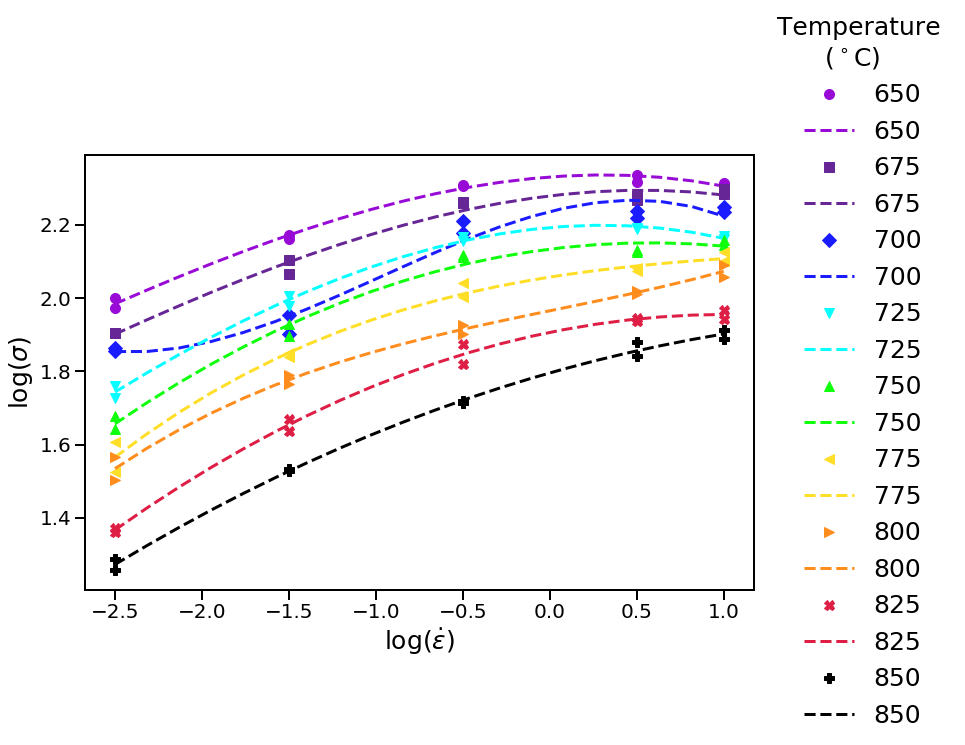

In [48]:
fit_pars_random_select=plot_proof_stress_random_select(proof_vals,n=3,rand_val=10,strain_step=5)

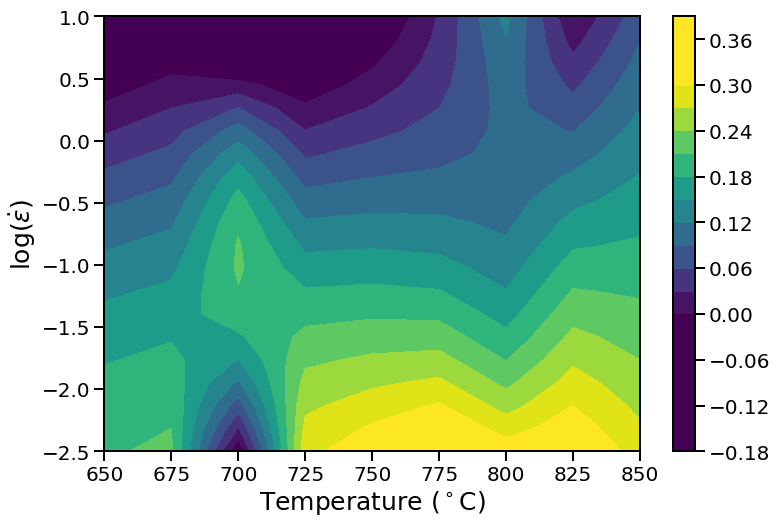

In [49]:
plot_m_contour(fit_pars_random_select)

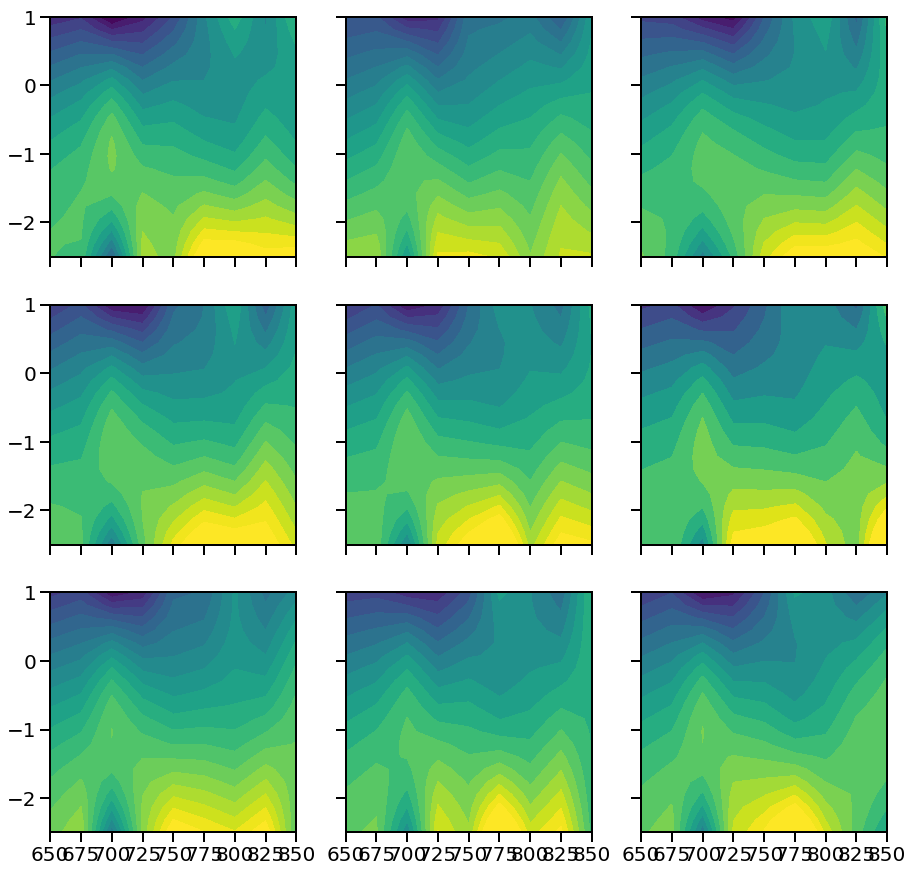

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [50]:
f,ax=plt.subplots(3,3,sharex='all',sharey='all',figsize=(15,15));
plt_pos=[(0,0),(0,1),(0,2),
             (1,0),(1,1),(1,2),
             (2,0),(2,1),(2,2)]
for pos in plt_pos:
    fit_pars_random=plot_proof_stress_random_select(proof_vals,n=3,rand_val=10,plotting=False,strain_step=5)
    plot_m_contour_simple(fit_pars_random,ax[pos]);